# Identificação de Alzaimer em imagens RX
* Mohammad Reza Tabrizi


# Otimização de hiperparâmetros
Os modelos anteriores apresentam performance interessante. Efetuar-se-á nesta secção um processo de otimização de hipermparâmetros, de modo a aumentar este valor, identificando quais os parâmetros mais adequados e que garantem uma precisão ótima.

Começamos por definir a função que alojará as várias topologias (convolucionais, pooling, dropout) e a taxa de dropout:

In [ ]:

def setup_model(topo_c, topo_p, dropout_rate, input_size, output_size):
  model = Sequential()
  model.add(Conv2D(topo_c[0], (3, 3), activation='relu', input_shape=(200,200,1)))
  if topo_p[0]==1: model.add(MaxPooling2D((2, 2)))
  if dropout_rate > 0: model.add(Dropout(dropout_rate))
  for i in range(1,len(topo_c)):
    model.add(Conv2D(topo_c[i], (3, 3), activation='relu'))
    if topo_p[i]==1: model.add(MaxPooling2D((2, 2)))
    if dropout_rate > 0: model.add(Dropout(dropout_rate))
  model.add(layers.Flatten())
  if dropout_rate > 0: model.add(Dropout(dropout_rate))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(4, activation='softmax'))
  return model

Na sequência define-se uma função que incorpora os vários algoritmos de treino, a loss e a métrica a usar, o número de epochs e o batch size:

In [ ]:
def train_cnn(model, alg, lr, Xtrain, Ytrain, epochs, batch_size):
  if alg == "adam":
    optimizer = optimizers.Adam(lr = lr)
  elif alg == "rmsprop":
    optimizer = optimizers.RMSprop(lr = lr)
  elif alg == "sgd_momentum":
   optimizer = optimizers.SGD(lr = lr, momentum = 0.9)
  else: optimizer = optimizers.SGD(lr = lr)

  model.compile(optimizer = optimizer, loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
  history=model.fit(Xtrain, Ytrain, epochs = epochs, batch_size = batch_size, verbose = 0,callbacks = callbacks)
  return model,history

A última função vai treinando os vários modelos, guardando configuração com a melhor performance:

In [ ]:
def cnn_optimization(opt_params, Xtrain, Ytrain, Xval, Yval, iterations, verbose = True):
  #verbose: producing detailed logging information
  from random import choice
  if verbose: print("Topology\tDropout\tAlgorithm\tLRate\tBatchSize\tEpochs\tValLoss\tValAcc\n")
  best_acc = None
  input_size = Xtrain.shape[0]
  output_size = Ytrain.shape[0]

  if "topology_c" in opt_params: topologies_c = opt_params["topology_c"]
  else: topologies_c = [[64,64,64]]
  if "topology_p" in opt_params: topologies_p = opt_params["topology_p"]
  else: topologies_p = [[1,1,1]]
  if "algorithm" in opt_params: algs = opt_params["algorithm"]
  else: algs = ["adam"]
  if "lr" in opt_params: lrs = opt_params["lr"]
  else: lrs = [0.001]
  if "dropout" in opt_params: dropouts = opt_params["dropout"]
  else: dropouts= [0.0]
  if "batch_size" in opt_params: batch_sizes = opt_params["batch_size"]
  else: batch_sizes= [512]
  if "epochs" in opt_params: epoch = opt_params["epochs"]
  else: epoch= [5]

  for it in range(iterations):
    #print('Iteração', it+1, 'de', iterations)
    #random item from the list
    topo_c = choice(topologies_c)
    topo_p = choice(topologies_p)   
    dropout_rate = choice(dropouts)
    dnn = setup_model (topo_c,topo_p, dropout_rate, input_size, output_size)
    alg = choice(algs)
    lr = choice(lrs)
    bs=choice(batch_sizes)
    epo=choice(epoch)

    dnn, history = train_cnn(dnn, alg, lr, Xtrain, Ytrain, epo, bs)
    val_loss, val_acc = dnn.evaluate(Xval, Yval, verbose = 0)
    if verbose:
      print(topo_c, "\t", topo_p, "\t", dropout_rate, "\t", alg, "\t", lr, "\t", bs, "\t", epo, "\t", val_loss, "\t", val_acc)
    if best_acc is None or val_acc > best_acc:
      best_acc = val_acc
      best_config = (topo_c, topo_p, dropout_rate, alg, lr, bs, epo)
      best_model=dnn
      best_history=history
    return best_config, best_acc,best_model,best_history

Listam-se os hiperparâmetros a otimizar:

In [ ]:
opt_pars = {
     "topology_c":[[64,64,64], [32,64,128], [16,32,64,128]],
     "topology_p":[[1,1,1,1,1], [1,0,1,0,1], [1,0,0,1,1]],#pooling constante ou intercalado
     "algorithm": ["adam","RMSprop"],
     "lr": [0.001, 0.0001], 
     "dropout": [0, 0.2],
     "batch_size":  [16,32,64,128],
     "epochs":[10]}

E inicia-se o treino dos modelos e a seleção do mais preditivo:

In [ ]:
best_config, best_val_acc,best_model,best_history=cnn_optimization(opt_pars, X_train, y_train, X_val, y_val, 10,verbose = True)


Topology	Dropout	Algorithm	LRate	BatchSize	Epochs	ValLoss	ValAcc



/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


[16, 32, 64, 128] 	 [1, 0, 1, 0, 1] 	 0.2 	 adam 	 0.0001 	 64 	 10 	 0.6428442327749162 	 0.7299107313156128


Treina-se de seguida a melhor configuração identificada para o modelo num conjunto de dados que engloba os dados de treino e validação.

In [ ]:
print("Best configuration:", best_config)
print("Best validation accuracy:", best_val_acc)
best_model = setup_model(best_config[0], best_config[1],best_config[2], X_train.shape[0],y_train.shape[0])
best_model, best_history = train_cnn(best_model, best_config[3], best_config[4], X_train,y_train,best_config[5],100)
test_loo, test_acc = best_model.evaluate(X_test, y_test, verbose = 0)
print("Test set metrics:", test_loo, test_acc)

history_model_CNN_API_2=model_CNN_API_2.fit(X_train, y_train, epochs=100,validation_data=(X_val,y_val),callbacks = callbacks)

Best configuration: ([16, 32, 64, 128], [1, 0, 1, 0, 1], 0.2, 'adam', 0.0001, 64, 10)
Best validation accuracy: 0.7299107313156128


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Test set metrics: 0.38688160352758133 0.9401041865348816


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 198, 198, 16)      160       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 99, 99, 16)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 99, 99, 16)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 97, 97, 32)        4640      
_________________________________________________________________
dropout_29 (Dropout)         (None, 97, 97, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 95, 95, 64)        18496     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 47, 47, 64)      

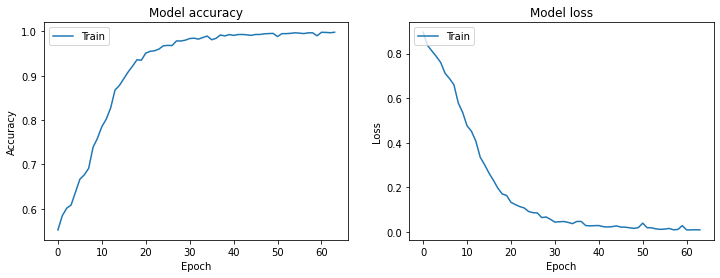

In [ ]:
best_model.summary()
tf.keras.utils.plot_model(best_model, "best_model.png", show_shapes = True)
output_metrics2(best_model,best_history,X_test, y_test)